In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization,Dense,SeparableConv2D,MaxPooling2D,Activation,Flatten,Dropout

In [ ]:
INIT_LR = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 50
lr_find = True
classes = ['Non_Fire','Fire']

In [ ]:
images = []
labels = []
for c in classes:
    try:
        for img in os.listdir('/content/drive/MyDrive/'+c):
            img = cv2.imread('/content/drive/MyDrive/'+c+'/'+img)
            img = cv2.resize(img,(128,128))
            images.append(img)
            labels.append([0,1][c=='Fire'])
    except:
        pass

images = np.array(images,dtype='float32')/255.

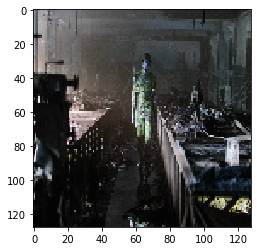

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(np.array(images[54]), interpolation='nearest')
plt.show()

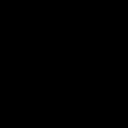

In [ ]:
from google.colab.patches import cv2_imshow
ind = np.random.randint(0,len(images))
cv2_imshow(images[ind])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
labels = np.array(labels)
labels = np_utils.to_categorical(labels,num_classes=2)

In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
d = {}
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals
d[0] = classWeight[0]
d[1] = classWeight[1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, shuffle=True, random_state=42)

In [ ]:
X_test.shape

(228, 128, 128, 3)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
import tensorflow
from tensorflow.keras.optimizers import SGD
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(16,(7,7),padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => POOL
model.add(SeparableConv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(len(classes)))
model.add(Activation("softmax"))

opt = tensorflow.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, momentum=0.9,decay=INIT_LR / NUM_EPOCHS)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 128, 128, 16)     211       
 Conv2D)                                                         
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 64, 64, 32)       688       
 leConv2D)                                              

In [ ]:
print("[INFO] training network...")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=d,
    verbose=1)
print("[INFO] serializing network to '{}'...".format('output/model'))
model.save('output/fire_detection.h5')

[INFO] training network...
Epoch 1/50
22/22 [==============================] - 14s 224ms/step - loss: 0.8151 - accuracy: 0.6472 - val_loss: 80.4557 - val_accuracy: 0.4757
Epoch 2/50
22/22 [==============================] - 5s 227ms/step - loss: 0.6476 - accuracy: 0.6975 - val_loss: 13.8787 - val_accuracy: 0.5032
Epoch 3/50
22/22 [==============================] - 7s 298ms/step - loss: 0.5909 - accuracy: 0.7396 - val_loss: 14.1337 - val_accuracy: 0.4693
Epoch 4/50
22/22 [==============================] - 5s 233ms/step - loss: 0.5507 - accuracy: 0.7472 - val_loss: 1.3960 - val_accuracy: 0.7209
Epoch 5/50
22/22 [==============================] - 5s 225ms/step - loss: 0.6013 - accuracy: 0.7263 - val_loss: 1.0635 - val_accuracy: 0.6934
Epoch 6/50
22/22 [==============================] - 5s 229ms/step - loss: 0.5647 - accuracy: 0.7470 - val_loss: 0.8728 - val_accuracy: 0.7632
Epoch 7/50
22/22 [==============================] - 6s 287ms/step - loss: 0.4935 - accuracy: 0.7803 - val_loss: 0.615

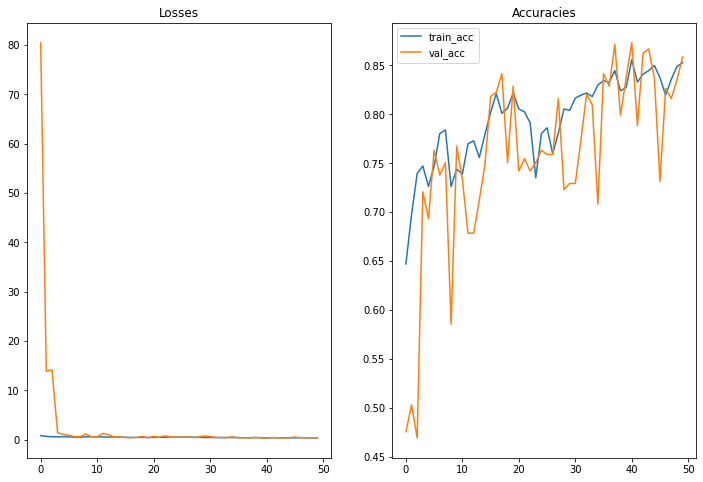

In [ ]:
N = np.arange(0, NUM_EPOCHS)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title("Losses")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.subplot(122)
plt.title("Accuracies")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.legend()
plt.savefig("output/training_plot.png")

In [ ]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('output/fire_detection.h5')

[INFO] loading model...


In [ ]:
temp_img = []
for i in range(50):
    random_index = np.random.randint(0,len(X_test))
    org_img = X_test[random_index]*255
    img = org_img.copy()
    img = cv2.resize(img,(128,128))
    img = img.astype('float32')/256
    pred = model.predict(np.expand_dims(img,axis=0))[0]
    result = classes[np.argmax(pred)]
    org_img = cv2.resize(org_img,(500,500))
    cv2.putText(org_img, result, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 3)
    cv2.imwrite('/content/output/testing/{}.png'.format(i),org_img)
    temp_img.append(org_img)

1/1 [==============================] - 0s 22ms/step


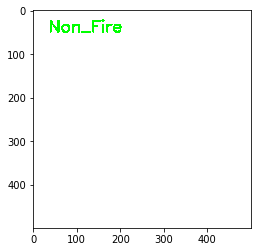

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(temp_img[10], interpolation='nearest')
plt.show()

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')